In [1]:
# import libraries
import os

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import transforms as T
from torch.utils.data import DataLoader, Subset, TensorDataset, SubsetRandomSampler
from torchvision.datasets import FashionMNIST

import torchvision

import sys

import matplotlib.pyplot as plt

import tqdm

import pandas as pd

from typing import Sequence, Tuple, Optional, List

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Import and Process Data

In [3]:
# transformations
transform = T.Compose([ T.ToTensor(),
                        T.Resize(64),
                        T.Normalize([.5,.5,.5],[.5,.5,.5])
                       ])

# import the data and simultaneously apply the transform
dataset = torchvision.datasets.CIFAR10(root='./data', download=True, transform=transform)

# transform to dataloaders
batchsize   = 512
data_loader = DataLoader(dataset,batch_size=batchsize,shuffle=True,drop_last=True)

100%|██████████| 170M/170M [00:03<00:00, 48.9MB/s]


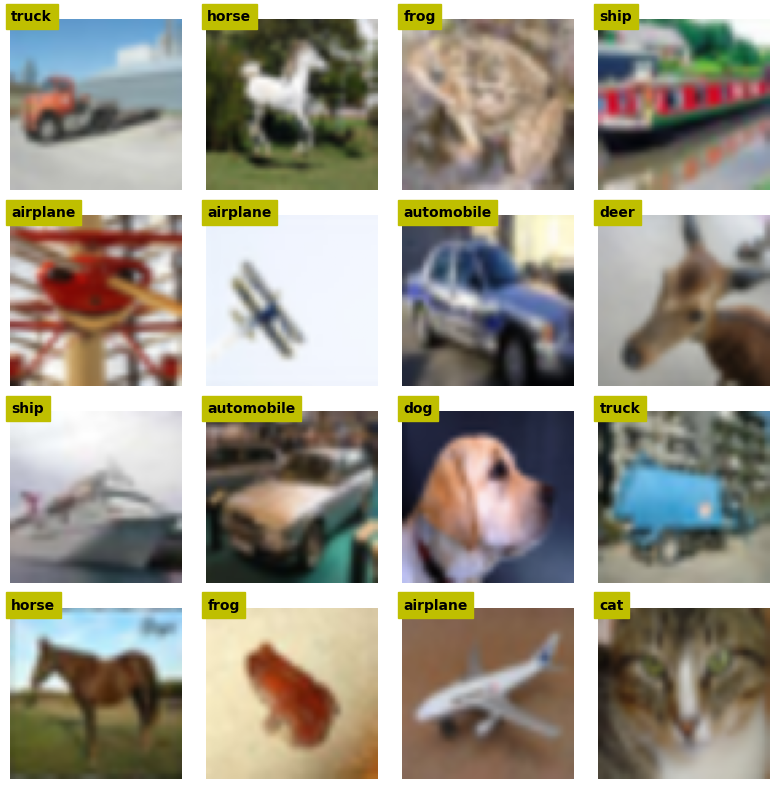

In [4]:
# inspect a few random images

X,y = next(iter(data_loader))

fig,axs = plt.subplots(4,4,figsize=(8,8))

for (i,ax) in enumerate(axs.flatten()):

  # extract that image (need to transpose it back to 32x32x3)
  pic = X.data[i].numpy().transpose((1,2,0))
  pic = pic/2 + .5 # undo normalization

  # and its label
  label = dataset.classes[y[i]]

  # and show!
  ax.imshow(pic)
  ax.text(0,0,label,ha='left',fontweight='bold',color='k',backgroundcolor='y')
  ax.axis('off')

plt.tight_layout()
plt.show();

# Create classes for the discriminator and generator

In [5]:
class discriminatorNet(nn.Module):
  def __init__(self):
    super().__init__()

    # convolution layers
    self.conv1 = nn.Conv2d(  3, 64, 4, 2, 1, bias=False)
    self.conv2 = nn.Conv2d( 64,128, 4, 2, 1, bias=False)
    self.conv3 = nn.Conv2d(128,256, 4, 2, 1, bias=False)
    self.conv4 = nn.Conv2d(256,512, 4, 2, 1, bias=False)
    self.conv5 = nn.Conv2d(512,  1, 4, 1, 0, bias=False)

    # batchnorm
    self.bn2 = nn.BatchNorm2d(128)
    self.bn3 = nn.BatchNorm2d(256)
    self.bn4 = nn.BatchNorm2d(512)

  def forward(self,x):
    x = F.leaky_relu( self.conv1(x) ,.2)
    x = F.leaky_relu( self.conv2(x) ,.2)
    x = self.bn2(x)
    x = F.leaky_relu( self.conv3(x) ,.2)
    x = self.bn3(x)
    x = F.leaky_relu( self.conv4(x) ,.2)
    x = self.bn4(x)
    return torch.sigmoid( self.conv5(x) ).view(-1,1)


dnet = discriminatorNet()
y = dnet(torch.randn(10,3,64,64))
y.shape

torch.Size([10, 1])